<a href="https://colab.research.google.com/github/ayush2281/Pytorch-for-ML-DL-/blob/main/07_Milestone_Project_1_PyTorch_Experiment_Tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#07 Milestone Project 1: PyTorch Experiment Tracking

**Note**: This notebook uses torchvision's new multi-weight support API (available in torchvision v0.13+)[new multi-weight support API (available in torchvision v0.13+)](https://pytorch.org/blog/introducing-torchvision-new-multi-weight-support-api/).

We've trained a fair few models now on the journey to making FoodVision Mini (an image classification model to classify images of pizza, steak or sushi).

And so far we've kept track of them via Python dictionaries.

Or just comparing them by the metric print outs during training.

What if you wanted to run a dozen (or more) different models at once?

Surely there's a better way...

There is.

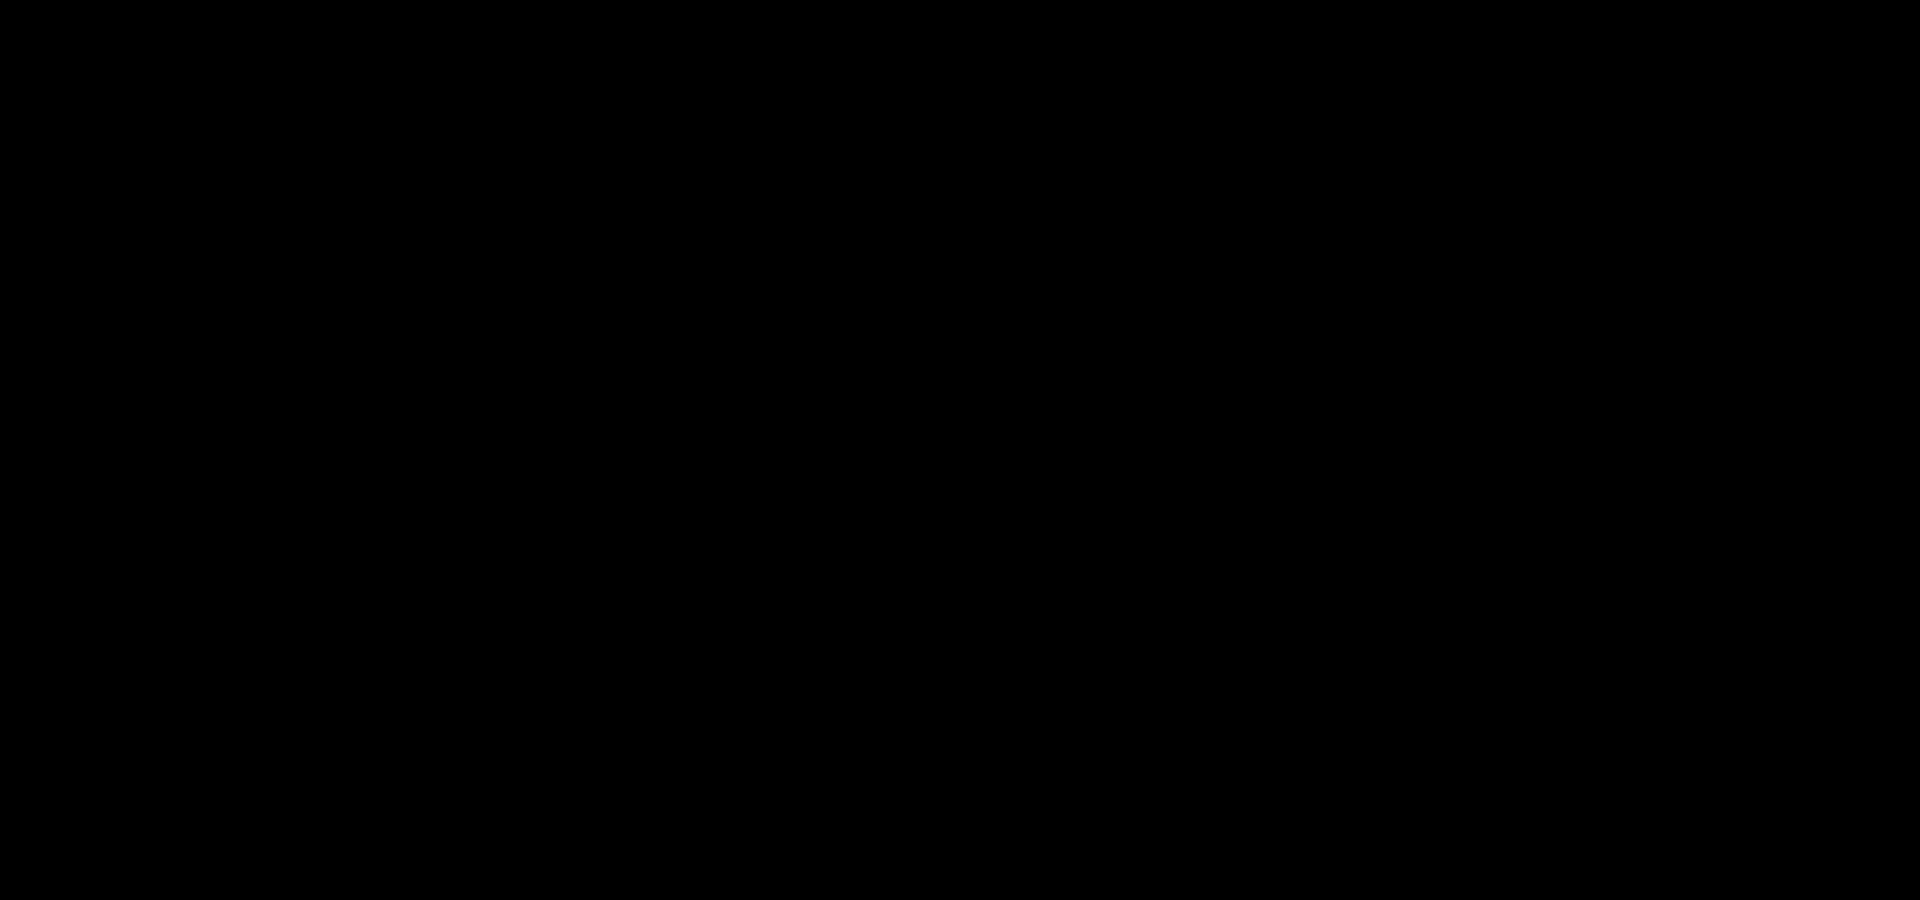

#**Experiment tracking**.

And since experiment tracking is so important and integral to machine learning, you can consider this notebook your first milestone project.

So welcome to Milestone Project 1: FoodVision Mini Experiment Tracking.

We're going to answer the question: **how do I track my machine learning experiments?**

#What is experiment tracking?
Machine learning and deep learning are very experimental.

You have to put on your artist's beret/chef's hat to cook up lots of different models.

And you have to put on your scientist's coat to track the results of various combinations of data, model architectures and training regimes.

That's where **experiment tracking** comes in.

If you're running lots of different **experiments, experiment tracking helps you figure out what works and what doesn't.**


#Why track experiments?
If you're only running a handful of models (like we've done so far), it might be okay just to track their results in print outs and a few dictionaries.

However, as the number of experiments you run starts to increase, this naive way of tracking could get out of hand.

So if you're following the machine learning practitioner's motto of experiment, experiment, experiment!, you'll want a way to track them.

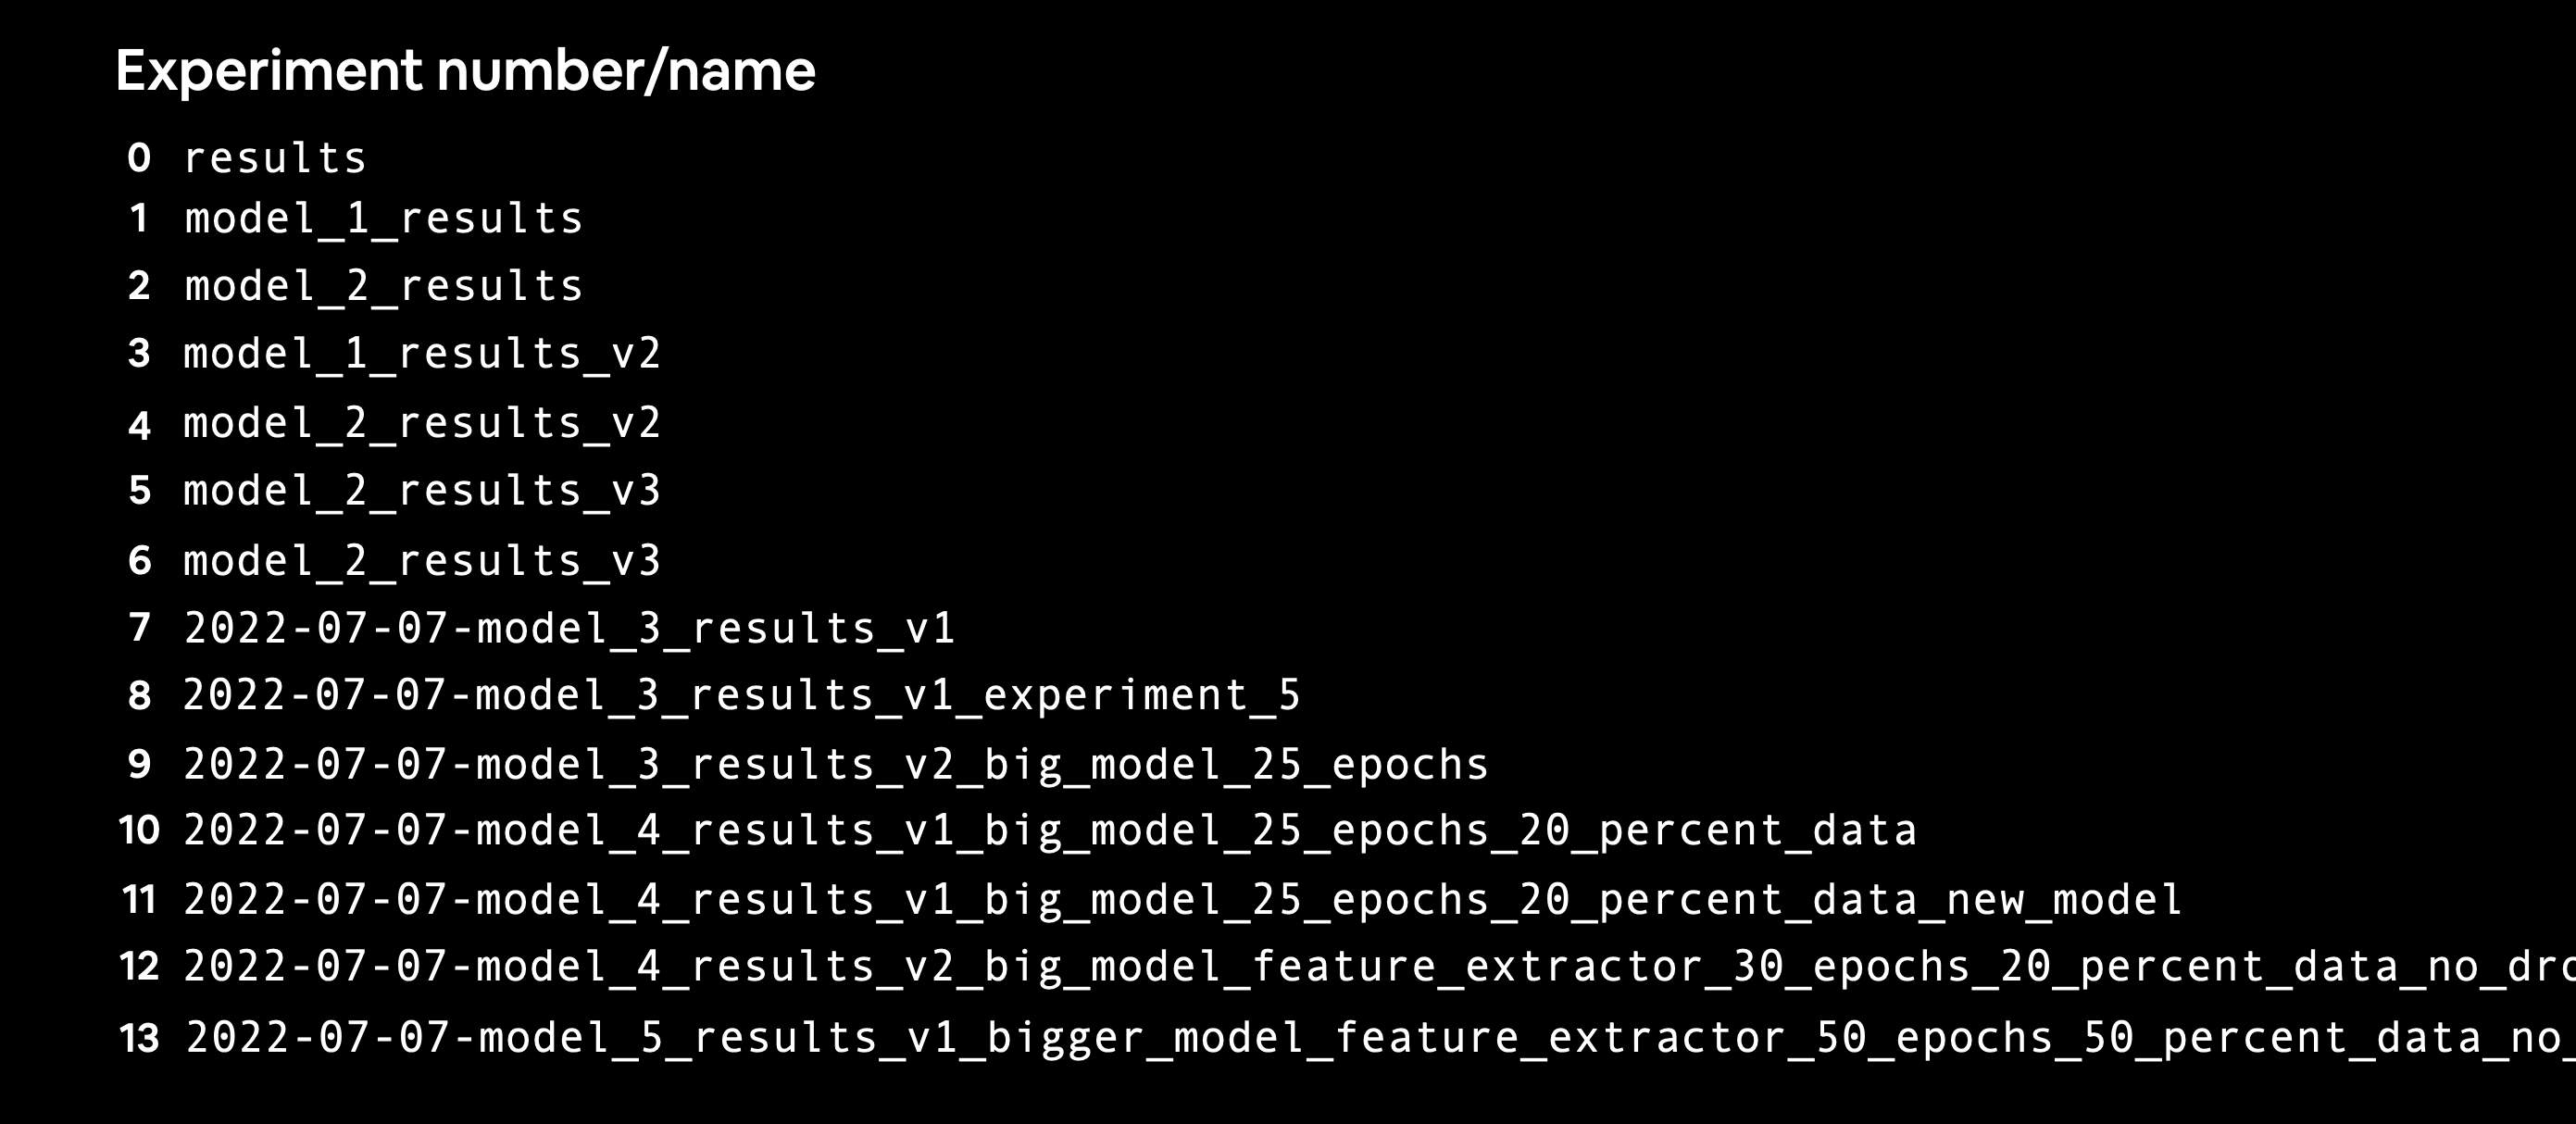

After building a few models and tracking their results, you'll start to notice how quickly it can get out of hand.

#Different ways to track machine learning experiments
There are as many different ways to track machine learning experiments as there are experiments to run.

This table covers a few.

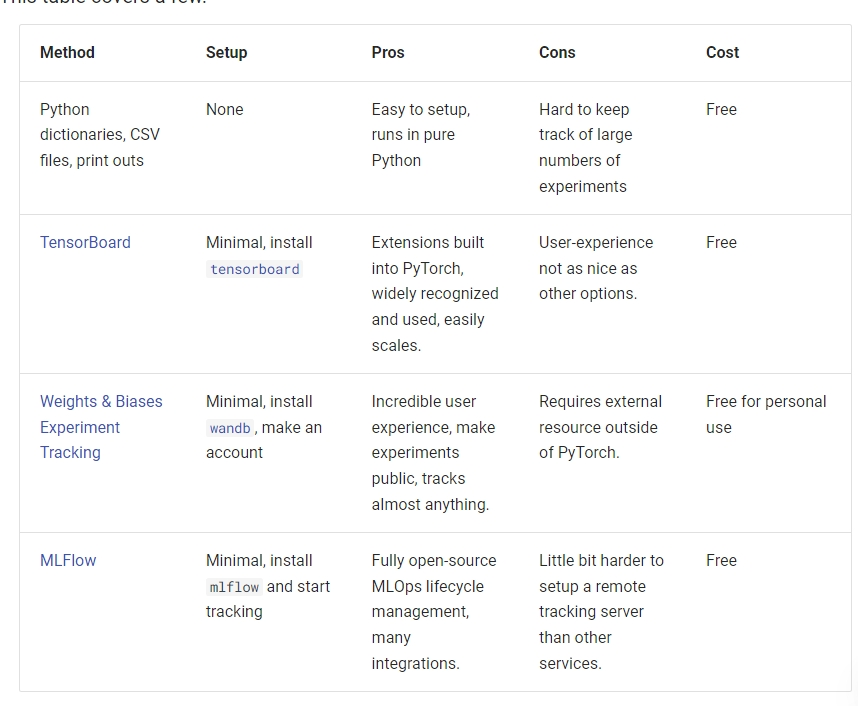

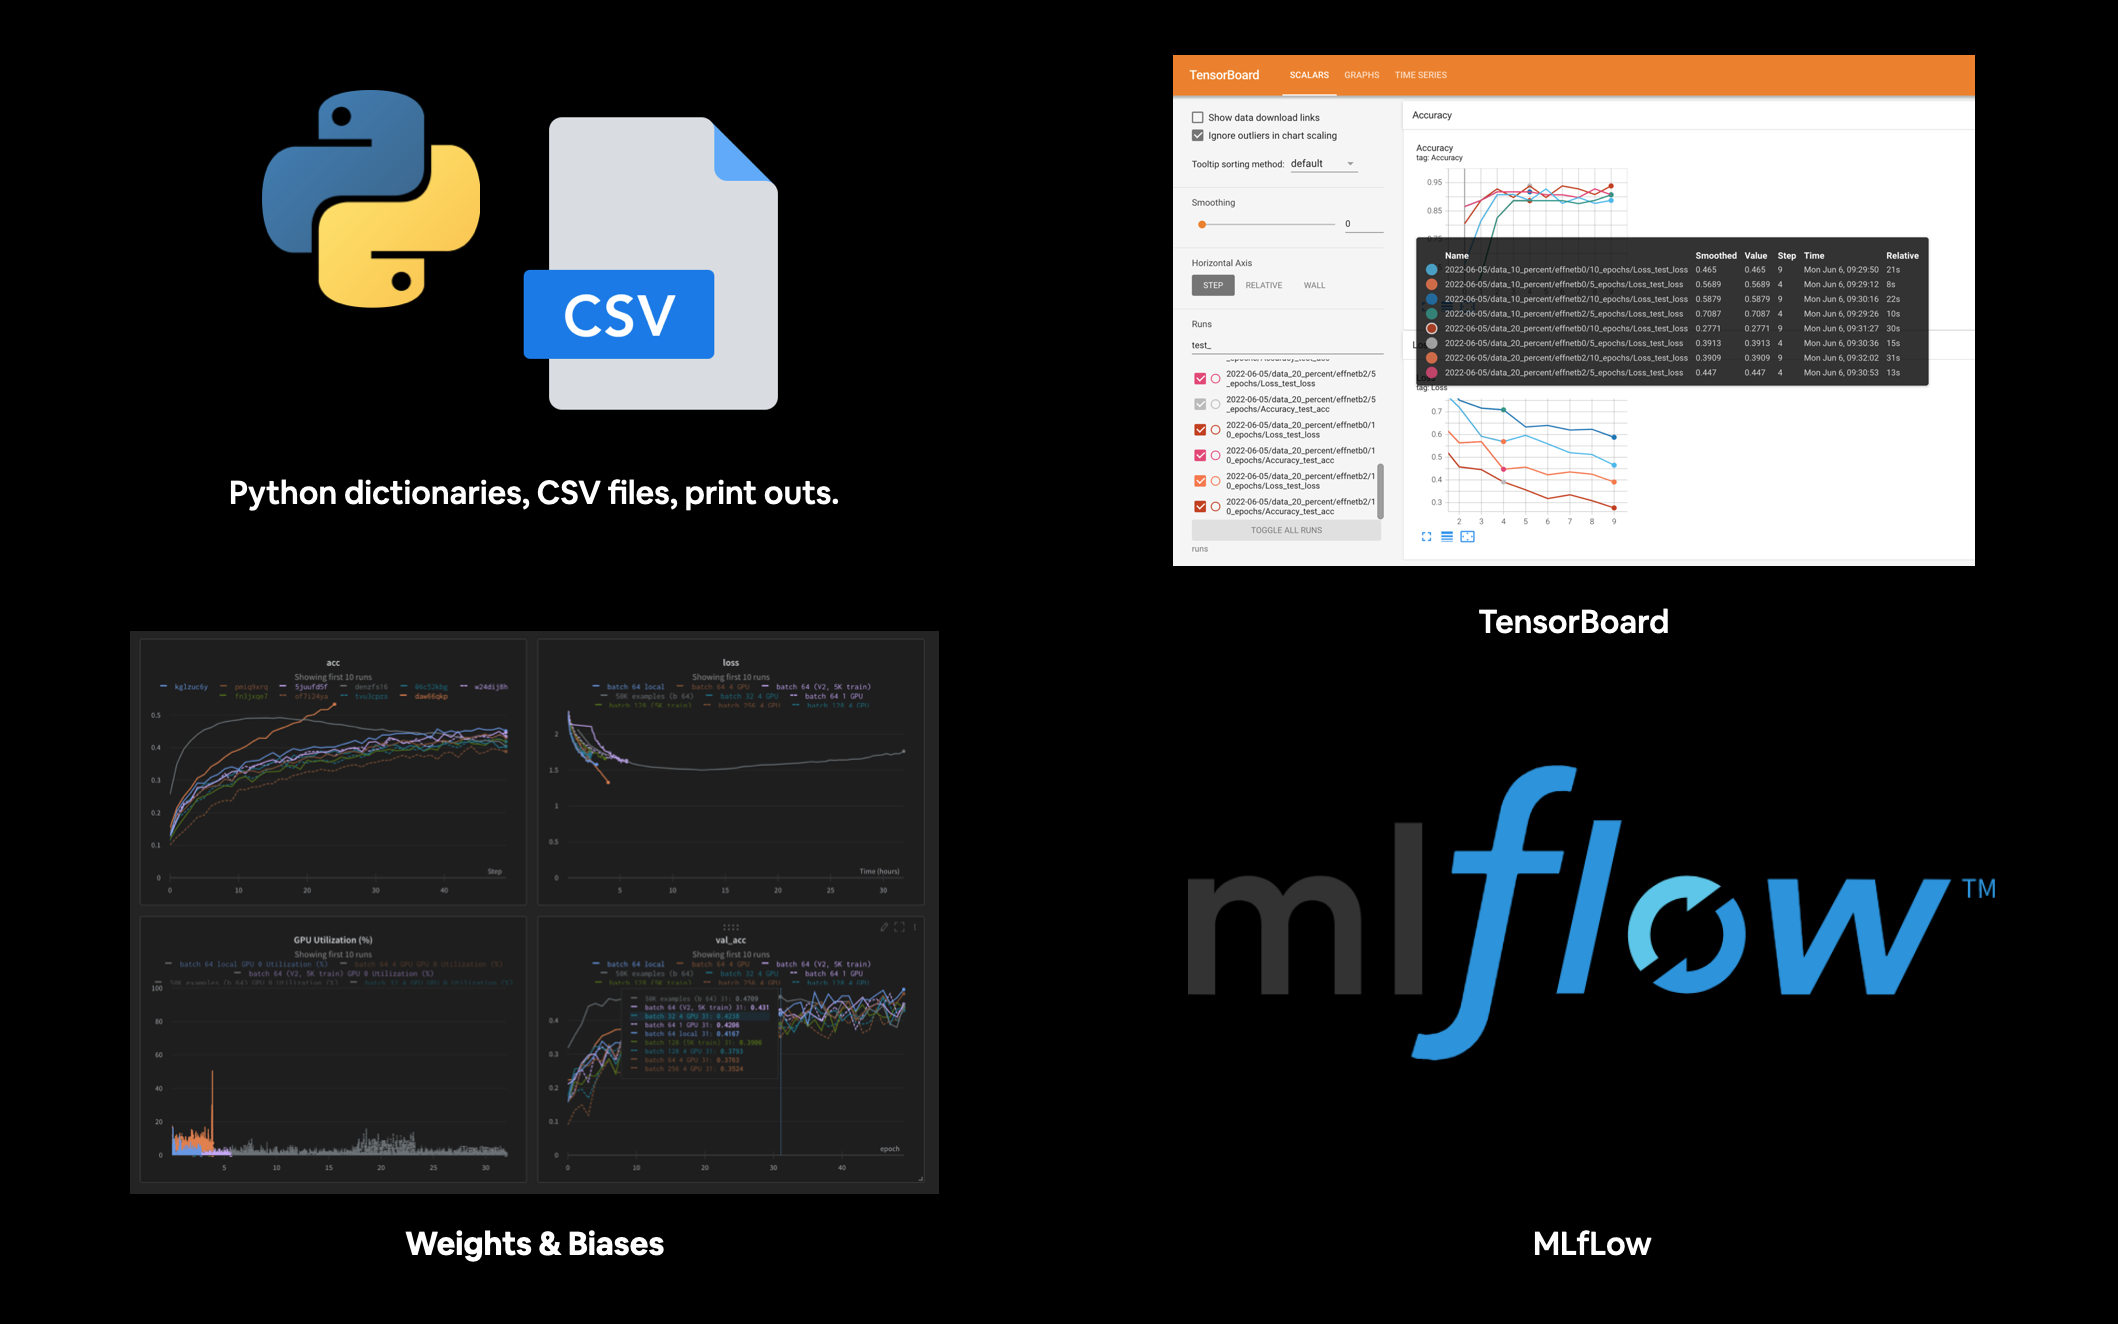


#What we're going to cover
We're going to be running several different modelling experiments with various levels of data, model size and training time to try and improve on FoodVision Mini.

And due to its tight integration with PyTorch and widespread use, this notebook focuses on using TensorBoard to track our experiments.

However, the principles we're going to cover are similar across all of the other tools for experiment tracking.

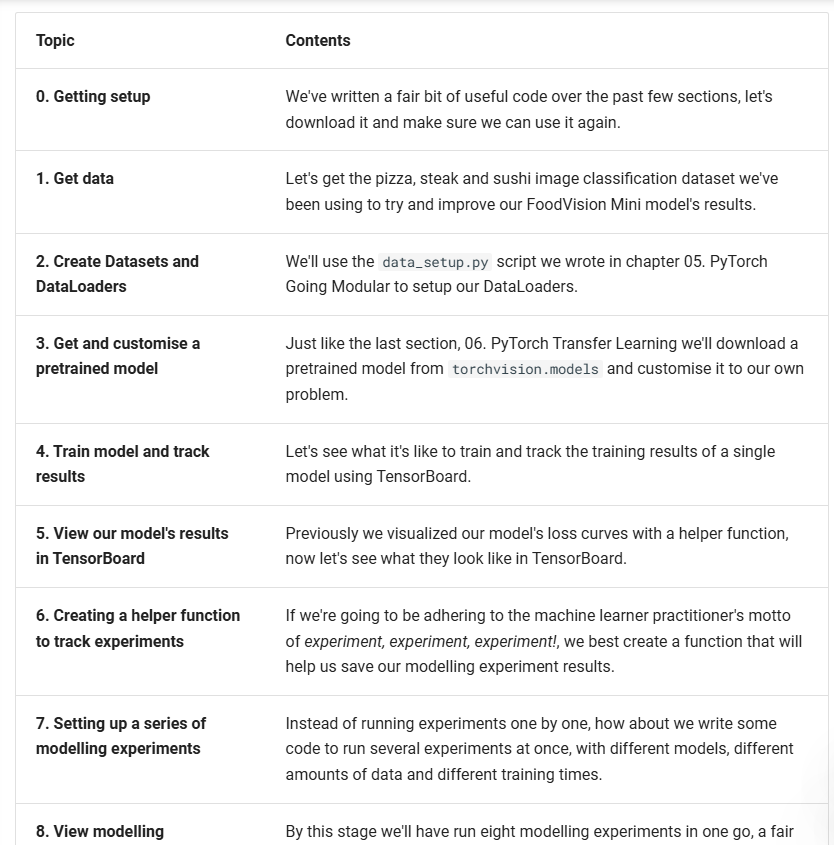

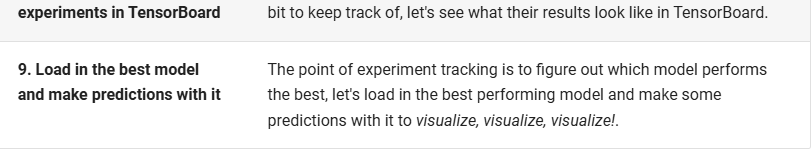


#0. Getting setup
Let's start by downloading all of the modules we'll need for this section.

To save us writing extra code, we're going to be leveraging some of the Python scripts (such as data_setup.py and engine.py) we created in section, `05. PyTorch Going Modular.`

Specifically, we're going to download the `going_modular` directory from the `pytorch-deep-learning` repository (if we don't already have it).

We'll also get the `torchinfo` package if it's not available.

`torchinfo` will help later on to give us visual summaries of our model(s).

And since we're using a newer version of the `torchvision` package (v0.13 as of June 2022), we'll make sure we've got the latest versions.

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+4
try:
  import torch
  import torchvision
  assert int(torch.__vision__.split(".")[1]) >=12, "torch version should be 1.12+"
  assert int(torchvision.__version__.split(".")[1]) >=13, "torchvision version should be 0.13"
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")
except:
  print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
  !pip install -U torchvision torchaudio --extra-index-url https://download.pytorch.org.whl/cu113
  import torch
  import torchvision
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org.whl/cu113
torch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124


Note: If you're using Google Colab, you may have to restart your runtime after running the above cell. After restarting, you can run the cell again and verify you've got the right versions of torch (0.12+) and torchvision (0.13+).

In [10]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 4356 (delta 213), reused 252 (delta 176), pack-reused 4035 (from 1)
Receiving objects: 100% (4356/4356), 654.51 MiB | 39.20 MiB/s, done.
Resolving deltas: 100% (2584/2584), done.
Updating files: 100% (248/248), done.



Now let's setup device agnostic code.

**Note**: If you're using Google Colab, and you don't have a GPU turned on yet, it's now time to turn one on via Runtime -> `Change runtime type -> Hardware accelerator -> GPU`.

In [11]:



device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

**Create a helper function to set seeds**
Since we've been setting random seeds a whole bunch throughout previous sections, how about we functionize it?

Let's create a function to "set the seeds" called set_seeds().

**Note**: Recalling a random seed is a way of flavouring the randomness generated by a computer. They aren't necessary to always set when running machine learning code, however, they help ensure there's an element of reproducibility (the numbers I get with my code are similar to the numbers you get with your code). Outside of an educational or experimental setting, random seeds generally aren't required.

In [12]:



# set seed
def set_seeds(seed: int:42):
  """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
     # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)



SyntaxError: invalid syntax (<ipython-input-12-60cd059455aa>, line 2)

#1. Get data
As always, before we can run machine learning experiments, we'll need a dataset.

We're going to continue trying to improve upon the results we've been getting on FoodVision Mini.

In the previous section, `06. PyTorch Transfer Learning`, we saw how powerful using a pretrained model and transfer learning could be when classifying images of pizza, steak and sushi.

So how about we run some experiments and try to further improve our results?

To do so, we'll use similar code to the previous section to download the `pizza_steak_sushi.zip` (if the data doesn't already exist) except this time it's been functionalised.

This will allow us to use it again later.

In [13]:

import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.

    Returns:
        pathlib.Path to downloaded data.

    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...")
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)

    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')


#2. Create Datasets and DataLoaders
Now we've got some data, let's turn it into PyTorch DataLoaders.

We can do so using the create_dataloaders() function we created in 05. PyTorch Going Modular part 2.

And since we'll be using transfer learning and specifically pretrained models from torchvision.models, we'll create a transform to prepare our images correctly.

To transform our images into tensors, we can use:

1. Manually created transforms using torchvision.transforms.
2. Automatically created transforms using
 `torchvision.models.MODEL_NAME.MODEL_WEIGHTS.DEFAULT.transforms().`
  * Where `MODEL_NAME` is a specific `torchvision.models` architecture, `MODEL_WEIGHTS` is a specific set of pretrained weights and DEFAULT means the "best available weights".
We saw an example of each of these in `06. PyTorch Transfer Learning section 2`.

Let's see first an example of manually creating a torchvision.transforms pipeline (creating a transforms pipeline this way gives the most customization but can potentially result in performance degradation if the transforms don't match the pretrained model).

The main manual transformation we need to be sure of is that all of our images are normalized in ImageNet format (this is because pretrained torchvision.models are all pretrained on ImageNet).

We can do this with:

 `normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])`

#2.1 Create DataLoaders using manually created transforms¶


Normalization vs. Standardization:

* Normalization: Typically scales data to a specific range, often between 0 and 1. In this case, it's subtracting the mean and dividing by the standard deviation for each color channel.
* Standardization: Transforms data to have a mean of 0 and a standard deviation of 1. This can also be used in image preprocessing, but the specific formula might differ slightly.

In [14]:
# Setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup ImageNet normalization levels (turns all images into similar distribution as ImageNet)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])
print(f"Manually created transforms: {manual_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x7a2328992680>,
 ['pizza', 'steak', 'sushi'])


#2.2 Create DataLoaders using automatically created transforms
Data transformed and DataLoaders created!

Let's now see what the same transformation pipeline looks like but this time by using automatic transforms.

We can do this by first instantiating a set of pretrained weights (for example `weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT)`we'd like to use and calling the `transforms()` method on it.

In [17]:
# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup pretrained weights (plenty of these available in torchvision.models)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms from weights (these are the transforms that were used to obtain the weights)
automatic_transforms = weights.transforms()
print(f"Automatically created transforms: {automatic_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms, # use automatic created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names


Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x7a232ef0a710>,
 ['pizza', 'steak', 'sushi'])

**the goal of the 2.1(dataloader) cell 14 and 2.2 cell (17) is same , we are using manually in the cell 17 by giving them value of the normalization and satandardizatipn by hand with help of ImageNet and in t7 we are using the pretrained weight model torchvision.models.EfficientNet_B0_Weights.DEFAULT**  

#3. Getting a pretrained model, freezing the base layers and changing the classifier head
Before we run and track multiple modelling experiments, let's see what it's like to run and track a single one.

And since our data is ready, the next thing we'll need is a model.

Let's download the pretrained weights for a torchvision.models.efficientnet_b0() model and prepare it for use with our own data.

In [18]:
# Note: This is how a pretrained model would be created in torchvision > 0.13, it will be deprecated in future versions.
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD

# Download the pretrained weights for EfficientNet_B0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # NEW in torchvision 0.13, "DEFAULT" means "best weights available"

# Setup the model with the pretrained weights and send it to the target device
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

# View the output of the model
# model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 66.3MB/s]


Wonderful!

Now we've got a pretrained model let's turn it into a feature extractor model.

In essence, we'll freeze the base layers of the model (we'll use these to extract features from our input images) and we'll change the classifier head (output layer) to suit the number of classes we're working with (we've got 3 classes: pizza, steak, sushi).

 **Note**: The idea of creating a feature extractor model (what we're doing here) was covered in more depth in 06. PyTorch Transfer Learning section 3.2: Setting up a pretrained model.

In [22]:
import random
import torch

def set_seeds(seed: int = 42):
    """Sets random seeds for reproducibility."""
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True  # Note: This may slow down training.


In [23]:
# Freeze all base layers by setting requires_grad attribute to False
for param in model.features.parameters():
    param.requires_grad = False

# Since we're creating a new layer with random weights (torch.nn.Linear),
# let's set the seeds
set_seeds()

# Update the classifier head to suit our problem
model.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True), # prevent the model from the overfitiing using regularization techniques and p=0.2 means each neurons have 20% probabiliry to drop
    nn.Linear(in_features=1280,
              out_features=len(class_names),
              bias=True).to(device))


Base layers frozen, classifier head changed, let's get a summary of our model with torchinfo.summary().

In [24]:
from torchinfo import summary

# # Get a summary of the model (uncomment for full output)
summary(model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

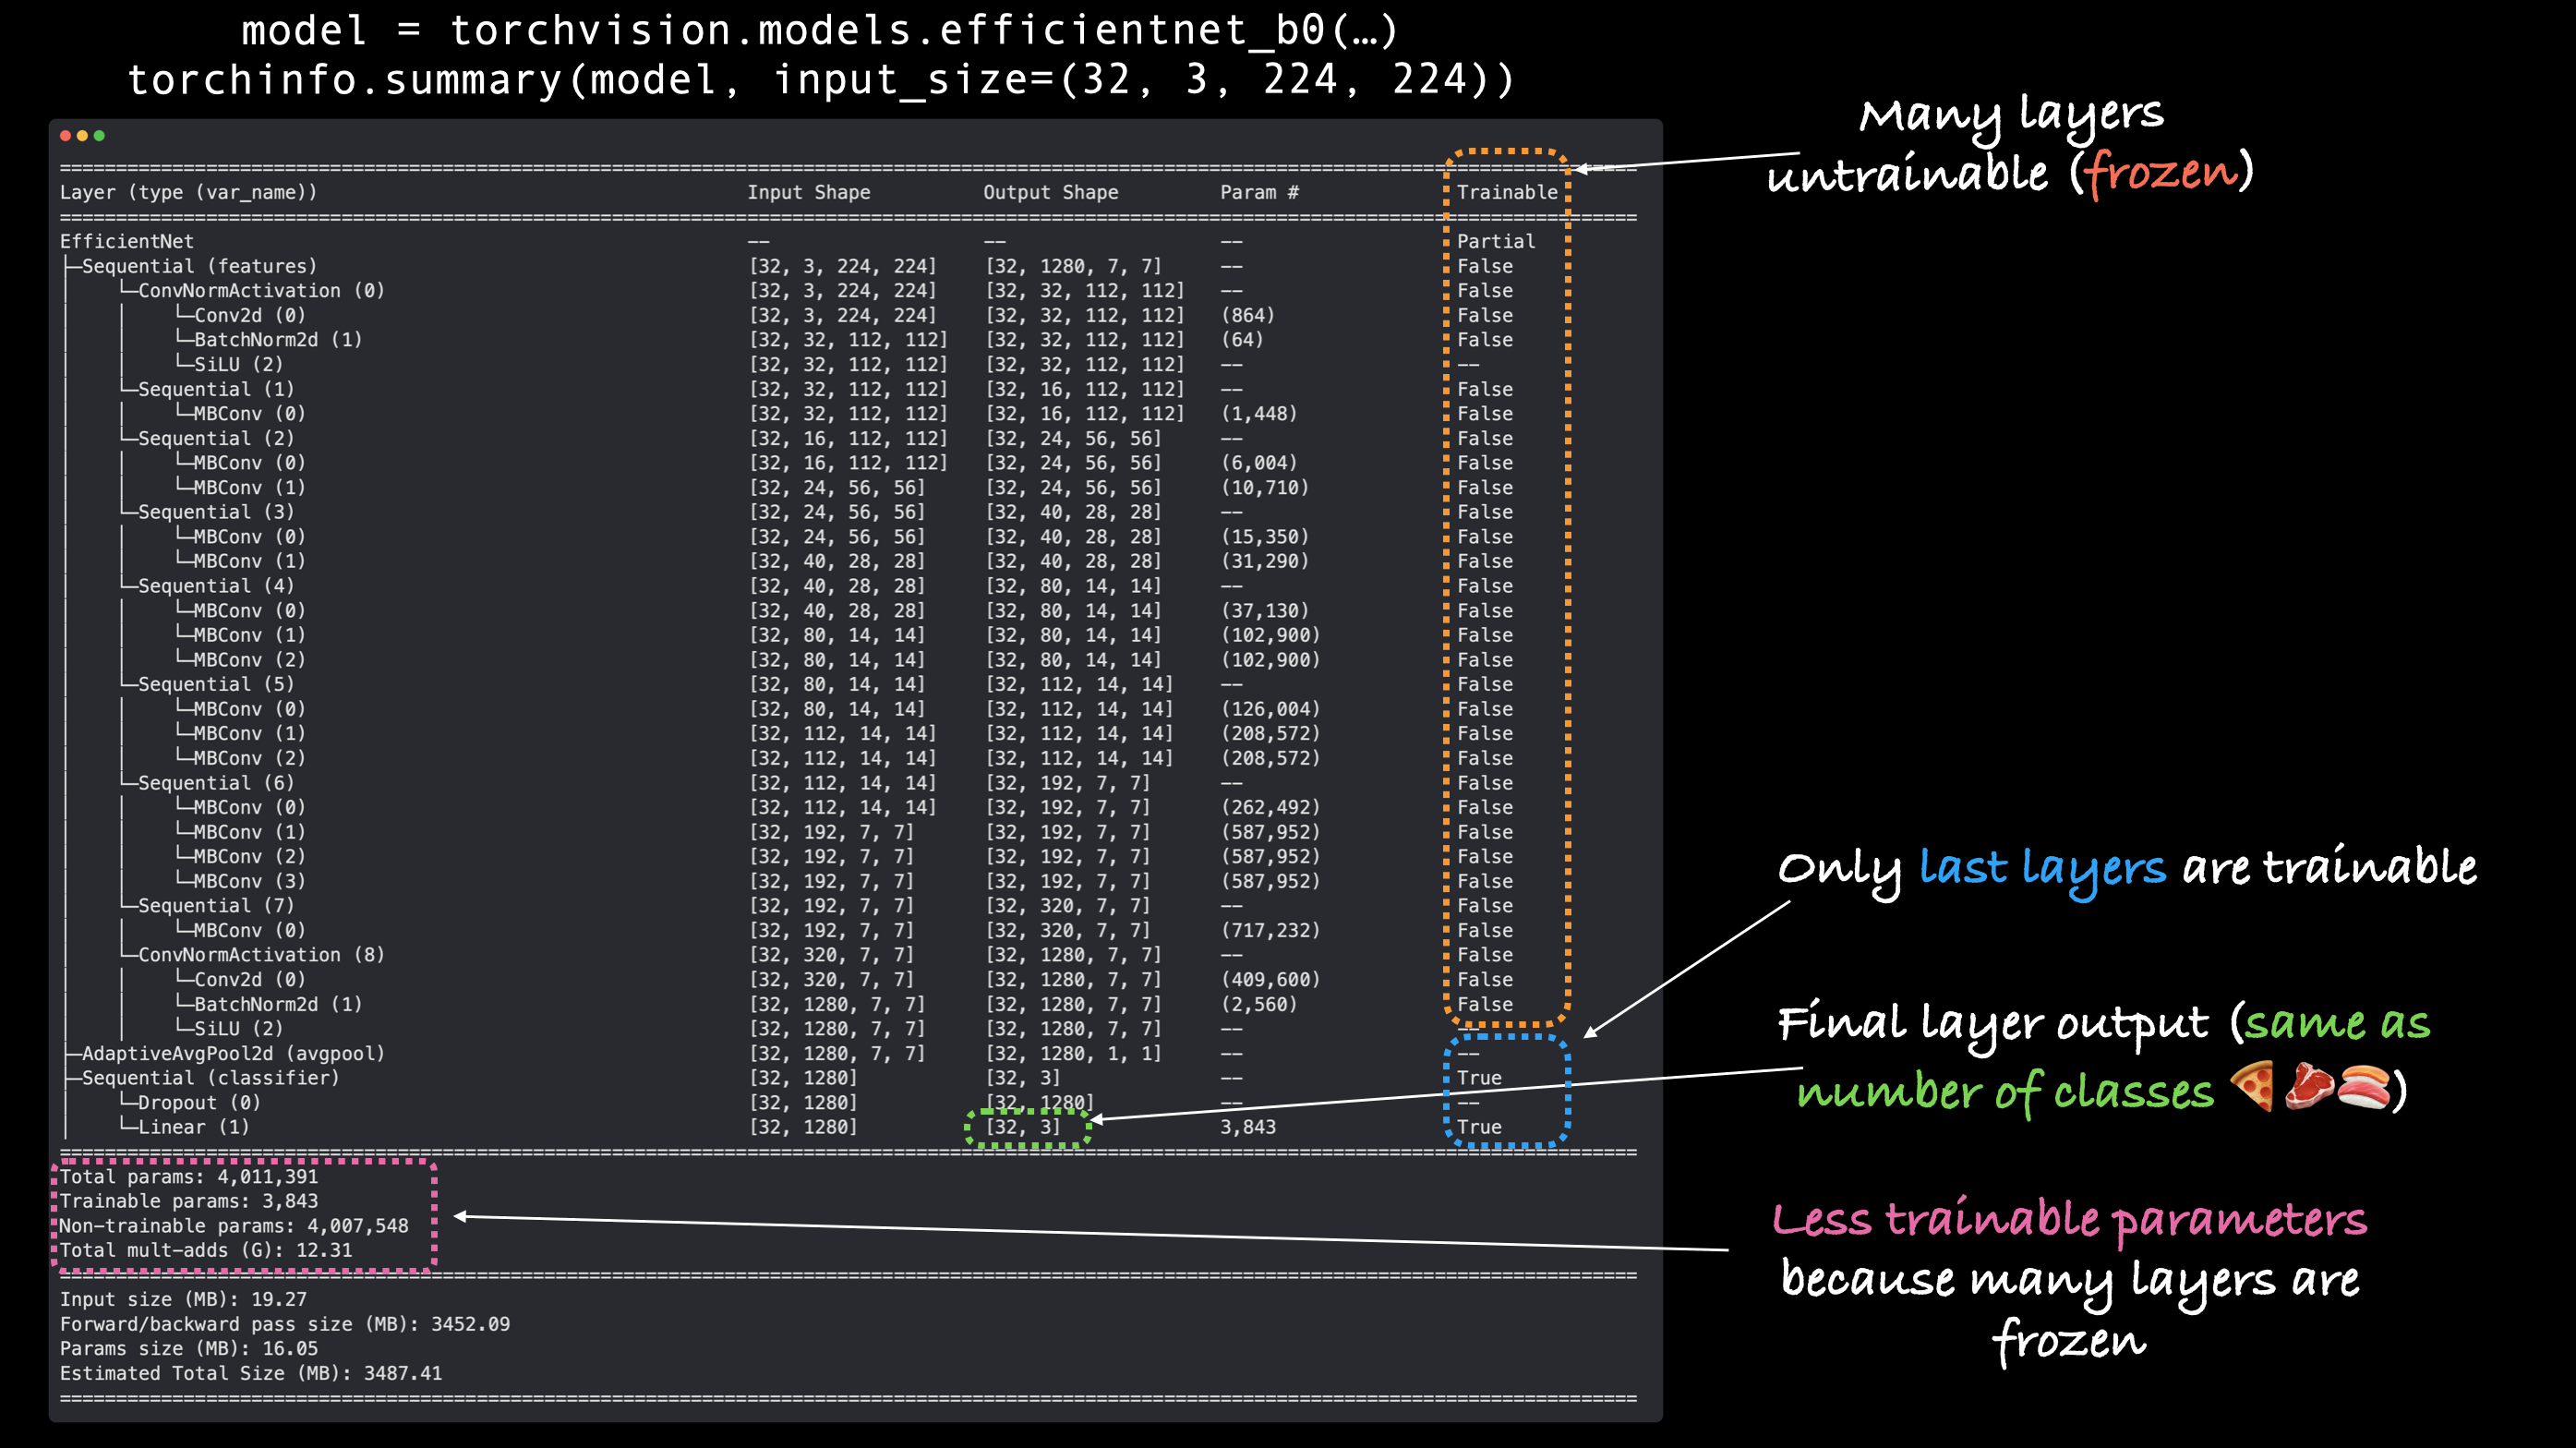

utput of torchinfo.summary() with our feature extractor EffNetB0 model, notice how the base layers are frozen (not trainable) and the output layers are customized to our own problem.

#4. Train model and track results
Model ready to go!

Let's get ready to train it by creating a loss function and an optimizer.

Since we're working with multiple classes, we'll use torch.nn.CrossEntropyLoss() as the loss function.

And we'll stick with torch.optim.Adam() with learning rate of 0.001 for the optimizer.

In [26]:
# define losss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer =torch.optim.Adam(model.parameters(), lr=0.001)


#Adjust `train()` function to track results with `SummaryWriter()`
Beautiful!

All of the pieces of our training code are starting to come together.

Let's now add the final piece to track our experiments.

Previously, we've tracked our modelling experiments using multiple Python dictionaries (one for each model).

But you can imagine this could get out of hand if we were running anything more than a few experiments.

Not to worry, there's a better option!

We can use PyTorch's `torch.utils.tensorboard.SummaryWriter()` class to save various parts of our model's training progress to file.

By default, the `SummaryWriter()` class saves various information about our model to a file set by the `log_dir` parameter.

The default location for `log_dir` is under `runs/CURRENT_DATETIME_HOSTNAME`, where the HOSTNAME is the name of your computer.

But of course, you can change where your experiments are tracked (the filename is as customisable as you'd like).

The outputs of the SummaryWriter() are saved in[Tensor Board](https://www.tensorflow.org/tensorboard) format.

TensorBoard is a part of the TensorFlow deep learning library and is an excellent way to visualize different parts of your model.

To start tracking our modelling experiments, let's create a default SummaryWriter() instance

In [28]:
try:
  from torch.utils.tensorboard import SummaryWriter

except:
  !print(f"[INFo] Could'nt find tensorbaord... installing it..")
  !pip install -q tensorboard
  from torch.utils.tensorboard import SummaryWriter

# create a writer witha alll default setting
writer = SummaryWriter()


Now to use the writer, we could write a new training loop or we could adjust the existing `train()` function we created in 05. PyTorch Going Modular section 4.

Let's take the latter option.

We'll get the `train()` function from `engine.py` and adjust it to use writer.

Specifically, we'll add the ability for our `train()` function to log our model's training and test loss and accuracy values.

We can do this with `writer.add_scalars(main_tag, tag_scalar_dict),` where:

* `main_tag (string)` - the name for the scalars being tracked (e.g. "Accuracy")
* `tag_scalar_dict (dict)`- a dictionary of the values being tracked (e.g. {"train_loss": 0.3454})
 * **Note**: The method is called add_scalars() because our loss and accuracy values are generally scalars (single values).

Once we've finished tracking values, we'll call `writer.close()` to tell the writer to stop looking for values to track.

To start modifying `train()` we'll also import `train_step()` and `test_step()` from engine.py.

 **Note**: You can track information about your model almost anywhere in your code. But quite often experiments will be tracked while a model is training (inside a training/testing loop).

The torch.utils.tensorboard.SummaryWriter() class also has many different methods to track different things about your model/data, such as add_graph() which tracks the computation graph of your model. For more options, check the SummaryWriter() documentation.

In [ ]:
from typing import Dict, List
from tqdm.auto import tqdm


from going_modular.going_modular.engine import train_step, test_step

# # Import train() function from:
# https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py

def train(model : torch.nn.Module,
          train_dataloader : torch.utils.data.Dataloader,
          test_dataloader: torch.utils.dataloader,
          optimizer: torch.optim.Optimizer,
          loss_fn : torch.nn.module,
          epochs: int ,
          device: torch.device) -> Dict[str, List]:



   """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]}
      For example if training for epochs=2:
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]}


